In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModelWithLMHead

from sklearn.cluster import KMeans

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
lyrics = pd.read_csv("../data/full.csv")

to_keep = ["track_name", "peak_pos", "album_name", "lyrics"]

lyrics = lyrics[to_keep]
lyrics['peak_pos_bucketed'] = lyrics['peak_pos'].apply(lambda x: '>100' if pd.isna(x) else str(int(x//10)*10) + '-' + str(int(x//10)*10 + 9))
lyrics.head()

,track_name,peak_pos,album_name,lyrics,peak_pos_bucketed
0,...Ready For It?,4.0,reputation,knew he was a killer first time that i saw him...,0-9
1,'tis the damn season,39.0,evermore,if i wanted to know who you were hanging with ...,30-39
2,"""Slut!"" (Taylor's Version) [From The Vault]",3.0,1989 (Taylor's Version),"flamingo pink, sunrise boulevard clink, clink,...",0-9
3,22,20.0,Red,it feels like a perfect night to dress up like...,20-29
4,22 (Taylor's Version),52.0,Red (Taylor's Version),it feels like a perfect night to dress up like...,50-59


In [39]:
# BERT for now, but I don't think it works too well
"""tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')"""


#This can be another model
tokenizer = AutoTokenizer.from_pretrained("huggingartists/taylor-swift")
model = AutoModelWithLMHead.from_pretrained("huggingartists/taylor-swift")

# This tokenizer doesn't have a padding token by default...
tokenizer.pad_token = tokenizer.eos_token


def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    
    with torch.no_grad(): 
        outputs = model(**inputs, output_hidden_states=True)

    embeddings = outputs.hidden_states[-1].mean(dim=1)
    #embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

In [40]:
# https://huggingface.co/huggingartists/taylor-swift
lyrics['latent_embedding'] = lyrics['lyrics'].apply(lambda x: encode_text(x))

In [41]:
embeddings = np.array([embedding.flatten() for embedding in lyrics['latent_embedding']])

# Reducing with TSNE down to two dimensions to see if we can visually assess any separation?
tsne = TSNE(n_components=2, random_state=256)
embeddings_2d = tsne.fit_transform(embeddings)

In [42]:
import plotly.graph_objects as go

def plot_embeddings_interactive(target_album=None, target_bucket=None):
    """
    This is a function so we can see if there are patterns among different buckets of billboard scores.
    It's a bit dizzying to look at everything overlaid...

    This plot is interactive to make encoding EDA not as painful
    """
    unique_albums = lyrics['album_name'].unique()
    album_colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_albums)))
    album_color_map = {album: f'rgb({int(col[0]*255)}, {int(col[1]*255)}, {int(col[2]*255)})' for album, col in zip(unique_albums, album_colors)}

    unique_buckets = lyrics['peak_pos_bucketed'].unique()
    peak_pos_colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_buckets)))
    peak_pos_color_map = {bucket: f'rgb({int(col[0]*255)}, {int(col[1]*255)}, {int(col[2]*255)})' for bucket, col in zip(unique_buckets, peak_pos_colors)}

    fig = go.Figure()

    # Ensuring embeddings_2d is a NumPy array for indexing
    embeddings_2d_np = np.array(embeddings_2d)

    # Add traces for album names
    for album in unique_albums:
        if target_album is not None and target_album != album:
            continue
        idx = lyrics['album_name'] == album
        selected_embeddings = embeddings_2d_np[idx]
        fig.add_trace(go.Scatter(x=selected_embeddings[:, 0], y=selected_embeddings[:, 1],
                                 mode='markers', marker=dict(color=album_color_map[album], opacity=0.7 if target_album is None or target_album == album else 0.2),
                                 name=album, text=lyrics[idx]['track_name']))

    # Add traces for peak position buckets, set to be initially hidden (visible on legend click)
    for bucket in unique_buckets:
        if target_bucket is not None and target_bucket != bucket:
            continue
        idx = lyrics['peak_pos_bucketed'] == bucket
        selected_embeddings = embeddings_2d_np[idx]
        fig.add_trace(go.Scatter(x=selected_embeddings[:, 0], y=selected_embeddings[:, 1],
                                 mode='markers', marker=dict(color=peak_pos_color_map[bucket], opacity=0.7 if target_bucket is None or target_bucket == bucket else 0.2),
                                 name=bucket, text=lyrics[idx]['track_name'],
                                 visible='legendonly'))

    fig.update_layout(title='Interactive Plot of Song Embeddings',
                      xaxis_title='TSNE 1',
                      yaxis_title='TSNE 2',
                      legend_title_text='Legend',
                      hovermode='closest')

    fig.show()




plot_embeddings_interactive()

Number of components to keep 95% of variance: 4


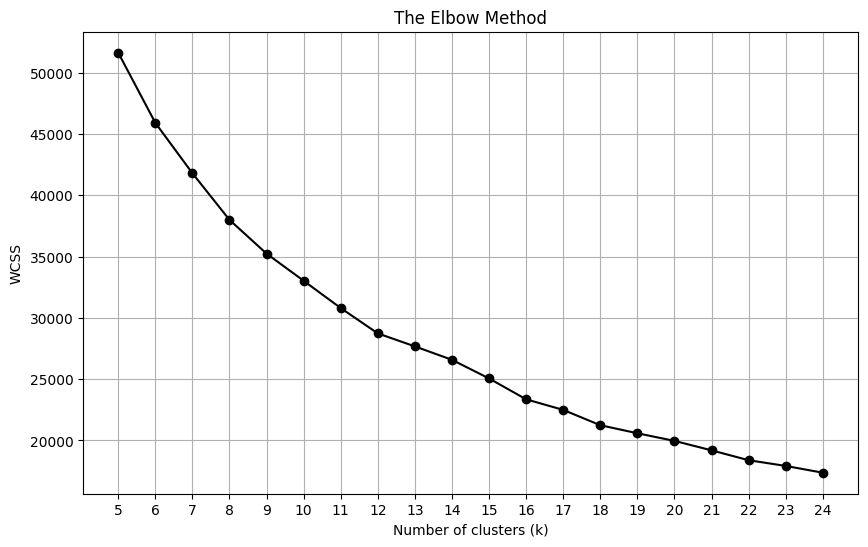

In [43]:

# Performing PCA to reduce the dimension before clustering
pca = PCA()

pca.fit(embeddings)
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components_95 = (cumulative_variance < 0.95).sum() + 1

print(f"Number of components to keep 95% of variance: {n_components_95}")

pca_95 = PCA(n_components=n_components_95)
reduced_data_95 = pca_95.fit_transform(embeddings)

k_values = range(5, 25) 
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=256, n_init=10)
    kmeans.fit(reduced_data_95)
    wcss.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, '-o', color='black')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_values)
plt.grid(True)
plt.show()

k = 10
kmeans = KMeans(n_clusters=k, random_state=256, n_init=10).fit(embeddings)
lyrics['cluster_assignment'] = kmeans.labels_

In [57]:
cluster_sizes = {}

for label in lyrics['cluster_assignment']:
    if label in cluster_sizes:
        cluster_sizes[label] += 1
    else:
        cluster_sizes[label] = 1

print(cluster_sizes)

clusters = lyrics[lyrics["cluster_assignment"] == 5]

{4: 39, 2: 37, 8: 34, 9: 21, 0: 40, 5: 30, 3: 55, 7: 22, 6: 25, 1: 24}


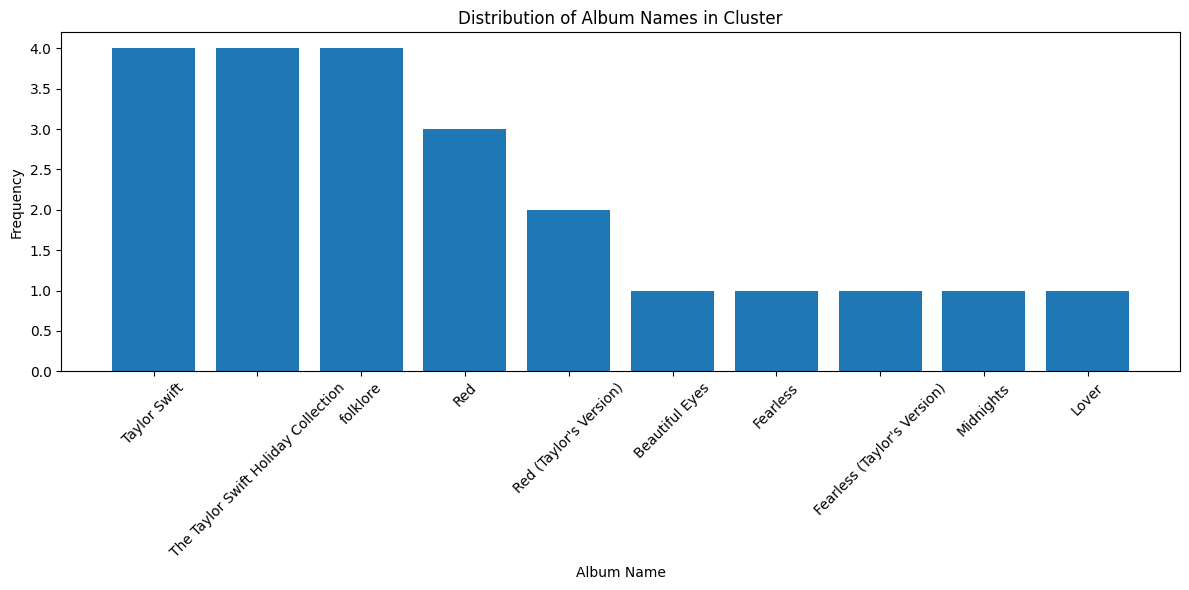

/var/folders/fs/v9vqgp9d5zb2fzzy63_b2gcr0000gn/T/ipykernel_22966/3362208884.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



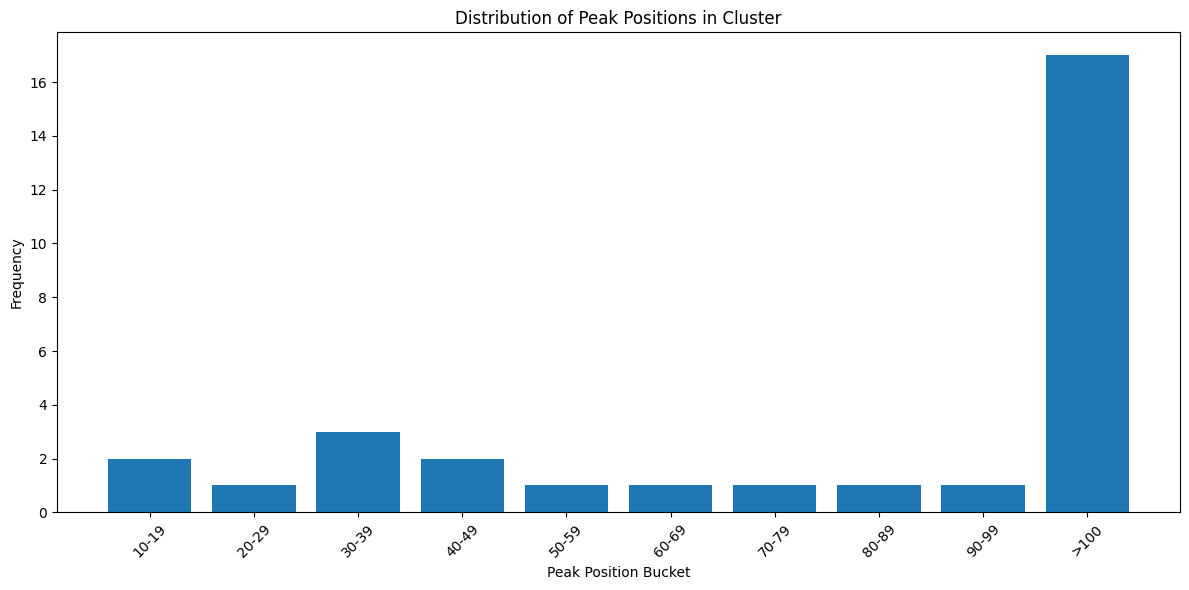

In [58]:
# Plotting the distribution for 'album_name'
plt.figure(figsize=(12, 6))
album_name_counts = clusters['album_name'].value_counts()
plt.bar(album_name_counts.index, album_name_counts.values)
plt.xlabel('Album Name')
plt.ylabel('Frequency')
plt.title('Distribution of Album Names in Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting the distribution for 'peak_pos'
plt.figure(figsize=(12, 6))

# Handling NaN values by categorizing them as >100
clusters['peak_pos_bucketed'] = clusters['peak_pos'].apply(lambda x: '>100' if pd.isna(x) else str(int(x//10)*10) + '-' + str(int(x//10)*10 + 9))

# Counting values in each bucket including the '>100' category
peak_pos_counts = clusters['peak_pos_bucketed'].value_counts().sort_index()

plt.bar(peak_pos_counts.index, peak_pos_counts.values)
plt.xlabel('Peak Position Bucket')
plt.ylabel('Frequency')
plt.title('Distribution of Peak Positions in Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
lyrics.to_csv("../data/full.csv", index=False)